In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
def otsu(image_mono, round=False,rounds=1):
  # this function is used to carry out otsu thresholding and return the mask.
  min_threshold=0   # initial threshold
  k_rounds=[]   
  mask_img_rounds=[]
  for rnd in range(rounds):
    #count,_= np.histogram(image_mono,bins=256-min_threshold, range=(0,255))
    count,_= np.histogram(image_mono.flatten(),bins=np.arange(min_threshold-0.5,256))
    freq, sigma_bsquare = np.zeros((256,)),np.zeros((256,))
    freq[min_threshold:]=count/np.max(count)
    for i in range(min_threshold,256):
      omega0 = np.sum(freq[min_threshold:i+1])
      omega1 = np.sum(freq[i+1:])
      mu0 = np.sum(freq[min_threshold:i+1]*np.arange(min_threshold,i+1))
      mu1 = np.sum(freq[i+1:]*np.arange(i+1,256))
      sigma_bsquare[i] = omega0 * omega1 * (mu0-mu1) * (mu0-mu1)
    k_opt = np.argmax(sigma_bsquare)
    mask = (image_mono>k_opt)
    if round:
      min_threshold=k_opt
    else:
      break

  #return mask_img_rounds,k_rounds
  return np.uint8(mask),k_opt

In [ ]:
def get_otsu_image(image,round=False,rounds=[1,1,1],invert=[0,0,0],erosion=[3,1],dialation=[3,1]):
  # get different otsu thresholding for different channels and then combine the images to get final segmented image
  '''
    rounds : Number of trials for each channel
    invert : should the channels be inverted before thresholding (convert foreground to background and vice versa)
    erosion : should the eroision be performed. Arguments: [kernel size,number of times to apply]
    dilation : should the dilation be performed. Arguments: [kernel size,number of times to apply]
  '''
  R,G,B = image[:,:,0],image[:,:,1],image[:,:,2]
  Ri=255-R;Gi=255-G;Bi=255-B  # inverted images
  if invert[0]==1:
    R_masks,R_k=otsu(Ri,round,rounds[0])
  else:
    R_masks,R_k=otsu(R,round,rounds[0])
  if invert[1]==1:
    G_masks,G_k=otsu(Gi,round,rounds[1])
  else:
    G_masks,G_k=otsu(G,round,rounds[1])
  if invert[2]==1:
    B_masks,B_k=otsu(Bi,round,rounds[2])
  else:
    B_masks,B_k=otsu(B,round,rounds[2])

  ############ erosion on mask images #####################
  erosion_win=erosion[0]
  erosion_iterations=erosion[1]
  erosion_kernel = np.ones((erosion_win,erosion_win),np.uint8)
  R_masks = cv2.erode(R_masks,erosion_kernel,iterations = erosion_iterations)
  G_masks = cv2.erode(G_masks,erosion_kernel,iterations = erosion_iterations)
  B_masks = cv2.erode(B_masks,erosion_kernel,iterations = erosion_iterations)
  
  ############# dialation on eroded images ###########
  dialation_win=dialation[0]
  dialation_iterations=dialation[1]
  dialation_kernel = np.ones((dialation_win,dialation_win),np.uint8)
  R_masks = cv2.dilate(R_masks,dialation_kernel,iterations = dialation_iterations)
  G_masks = cv2.dilate(G_masks,dialation_kernel,iterations = dialation_iterations)
  B_masks = cv2.dilate(B_masks,dialation_kernel,iterations = dialation_iterations)
  
  plt.subplot(1,3,1)
  plt.imshow(R_masks,cmap='gray')
  seg_img = cv2.bitwise_and(G_masks,B_masks)
  plt.subplot(1,3,2)
  plt.imshow(G_masks,cmap='gray')
  seg_img = cv2.bitwise_and(seg_img,R_masks)
  plt.subplot(1,3,3)
  plt.imshow(B_masks,cmap='gray')
  plt.imsave("R_mask.jpg",R_masks,cmap='gray')
  plt.imsave("G_mask.jpg",G_masks,cmap='gray')
  plt.imsave("B_mask.jpg",B_masks,cmap='gray')
  return seg_img,[R_k,G_k,B_k]


In [ ]:
def get_contours(image):
  # function to extract contour from the image
  contour_img=np.zeros_like(image)
  for i in range(contour_img.shape[0]):
    for j in range(contour_img.shape[1]):
      if image[i,j]==1:
        window_img=image[i-1:i+2,j-1:j+2]
        if np.sum(window_img)!=9:
          contour_img[i,j]=255
  return contour_img

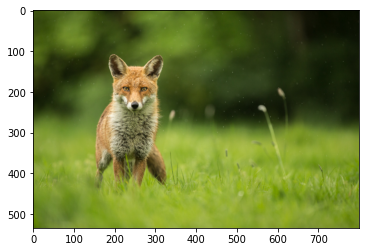

In [ ]:
im1 = cv2.imread("/content/drive/My Drive/hw6_images/Red-Fox_.jpg")
im1=cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
im1_gray = cv2.cvtColor(im1,cv2.COLOR_RGB2GRAY)

True

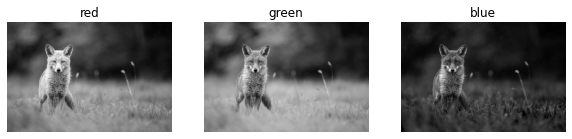

In [ ]:
(R, G, B) = (im1[:,:,0], im1[:,:,1], im1[:,:,2])
(iB, iG, iR) = (255-B, 255-G, 255-R)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(R,cmap='gray')
plt.axis('off')
plt.title("red")
plt.subplot(1,3,2)
plt.imshow(G,cmap='gray')
plt.axis('off')
plt.title("green")
plt.subplot(1,3,3)
plt.imshow(B,cmap='gray')
plt.axis('off')
plt.title("blue")
cv2.imwrite("fox_red.jpg",R)
cv2.imwrite("fox_green.jpg",G)
cv2.imwrite("fox_blue.jpg",B)

130 105 51


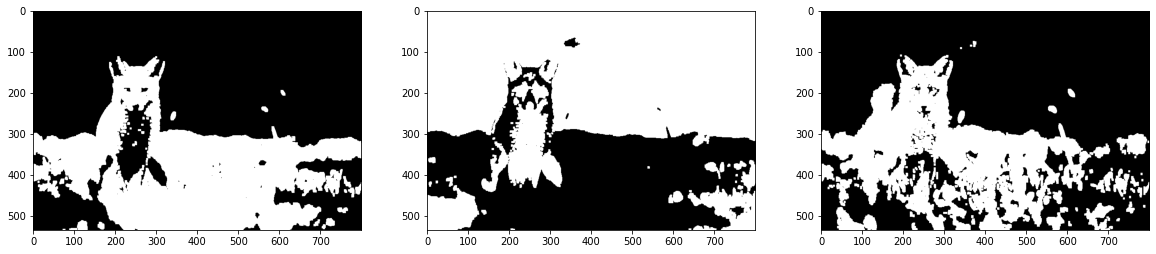

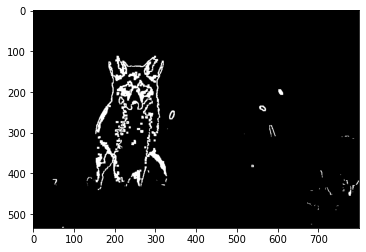

In [ ]:
plt.figure(figsize=(20,40))
seg_image,[R_k,G_k,B_k]=get_otsu_image(im1,round=True,rounds=[5,2,6],invert=[0,1,0],erosion=[3,1],dialation=[5,1])
plt.figure()
plt.imshow(seg_image.astype(int),cmap='gist_gray')
print(R_k,G_k,B_k)
plt.imsave("fox_seg.jpg",seg_image,cmap='gray')

True

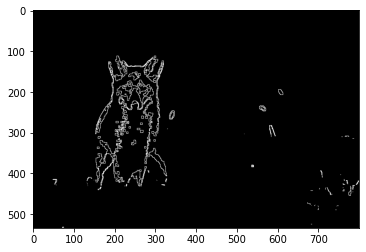

In [ ]:
contour_image = get_contours(seg_image)
plt.imshow(contour_image,cmap='gray')
cv2.imwrite("fox_contour.jpg",contour_image)

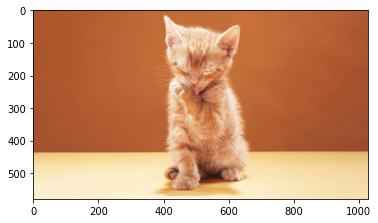

In [ ]:
im2 = cv2.imread("/content/drive/My Drive/hw6_images/cat.jpg")
im2=cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
plt.imshow(im2)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_RGB2GRAY)

True

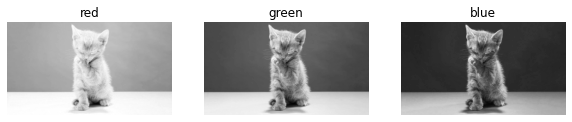

In [ ]:
(R, G, B) = (im2[:,:,0], im2[:,:,1], im2[:,:,2])
(iB, iG, iR) = (255-B, 255-G, 255-R)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(R,cmap='gray')
plt.axis('off')
plt.title("red")
plt.subplot(1,3,2)
plt.imshow(G,cmap='gray')
plt.axis('off')
plt.title("green")
plt.subplot(1,3,3)
plt.imshow(B,cmap='gray')
plt.axis('off')
plt.title("blue")
cv2.imwrite("cat_red.jpg",R)
cv2.imwrite("cat_green.jpg",G)
cv2.imwrite("cat_blue.jpg",B)

211 68 108


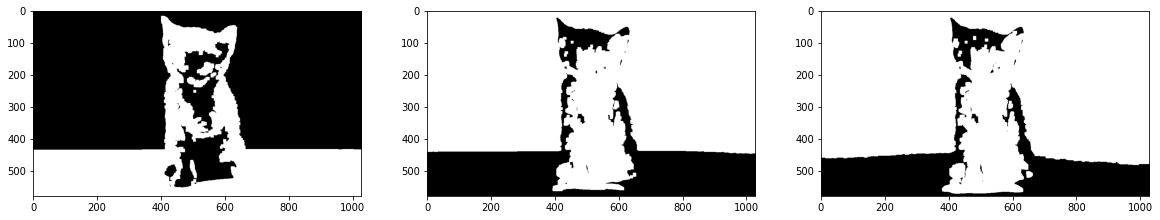

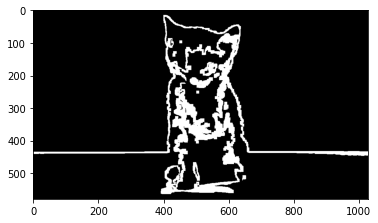

In [ ]:
plt.figure(figsize=(20,40))
seg_image2,[R_k,G_k,B_k]=get_otsu_image(im2,round=True,rounds=[7,1,1],invert=[0,1,1],erosion=[5,1],dialation=[5,2])
plt.figure()
plt.imshow(seg_image2.astype(int),cmap='gist_gray')
print(R_k,G_k,B_k)
plt.imsave("cat_seg.jpg",seg_image2,cmap='gray')

True

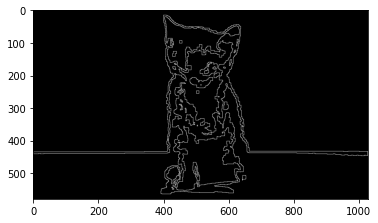

In [ ]:
contour_image2 = get_contours(seg_image2)
plt.imshow(contour_image2,cmap='gray')
cv2.imwrite("cat_contour.jpg",contour_image2)

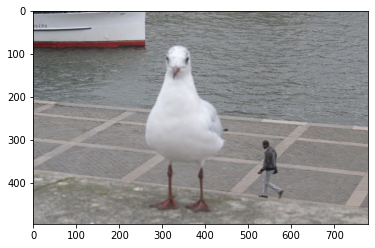

In [ ]:
im3 = cv2.imread("/content/drive/My Drive/hw6_images/pigeon.jpeg")
im3=cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)
plt.imshow(im3)
im3_gray = cv2.cvtColor(im3,cv2.COLOR_RGB2GRAY)

True

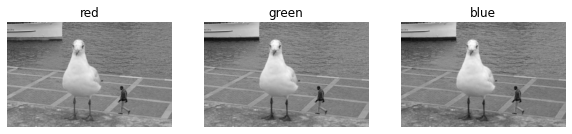

In [ ]:
(R, G, B) = (im3[:,:,0], im3[:,:,1], im3[:,:,2])
(iB, iG, iR) = (255-B, 255-G, 255-R)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(R,cmap='gray')
plt.axis('off')
plt.title("red")
plt.subplot(1,3,2)
plt.imshow(G,cmap='gray')
plt.axis('off')
plt.title("green")
plt.subplot(1,3,3)
plt.imshow(B,cmap='gray')
plt.axis('off')
plt.title("blue")
cv2.imwrite("pig_red.jpg",R)
cv2.imwrite("pig_green.jpg",G)
cv2.imwrite("pig_blue.jpg",B)

169 182 196


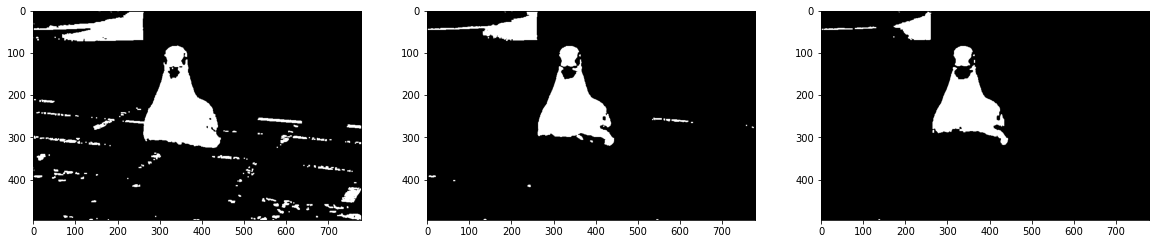

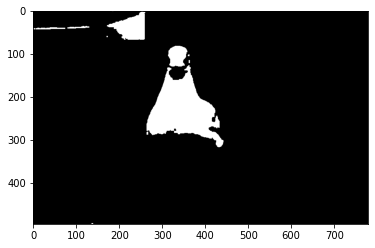

In [ ]:
plt.figure(figsize=(20,40))
seg_image3,[R_k,G_k,B_k]=get_otsu_image(im3,round=True,rounds=[15,19,20],invert=[0,0,0])
plt.figure()
plt.imshow(seg_image3.astype(int),cmap='gist_gray')
print(R_k,G_k,B_k)
plt.imsave("pigeon_seg.jpg",seg_image3,cmap='gray')

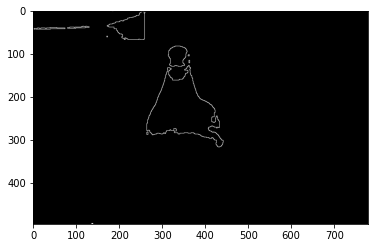

In [ ]:
contour_image3 = get_contours(seg_image3)
plt.imshow(contour_image3,cmap='gray')
plt.imsave("pig_contour.jpg",contour_image3,cmap='gray')

# Texture Based Segmentation:
in this method we first extract the texture based features of the image by computing the variance of the window and replacing the image pixels with the variance. 

This textured image is now passed through the Otsu's algorithm to get the segmented image.

In [ ]:
#### get texture from image #######
def get_var_image(image,window_size,pad_style='zeros'):
  #use the function to get texture based features from the grayscale images. The features are generated by calculating
  #the variance of the pixels inside a nxn window.
 
 #get the window
 win_size = window_size
 win_half=int((win_size-1)/2)
 win_half
 
 #pad the image with zeros to compute variance of edge pixels
 if pad_style=='zeros':
   pad_img = np.zeros((image.shape[0]+win_size-1,image.shape[1]+win_size-1))
   pad_img[win_half:pad_img.shape[0]-win_half,win_half:pad_img.shape[1]-win_half]=image

 if pad_style=='same':    # add 
   pass   
 
 if pad_style=='reflective':  # add
   pass
 
 #compute the variacnce
 var_img=np.zeros_like(pad_img)
 for i in range(win_half,pad_img.shape[0]-win_half):
   for j in range(win_half,pad_img.shape[1]-win_half):
     var_img[i,j]=np.var(pad_img[i-win_half:i+win_half+1,j-win_half:j+win_half+1])
 var_img = var_img[win_half:var_img.shape[0]-win_half,win_half:var_img.shape[1]-win_half]
 return var_img


In [ ]:
def get_texture_image(image,window_size=[3,5,7]):
  texture_image=np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
  texture_image[:,:,0]=get_var_image(image,window_size[0]).astype(np.uint8)
  texture_image[:,:,1]=get_var_image(image,window_size[1]).astype(np.uint8)
  texture_image[:,:,2]=get_var_image(image,window_size[2]).astype(np.uint8)
  return texture_image

In [ ]:
texture_image=get_texture_image(im1_gray,window_size=[3,5,7])

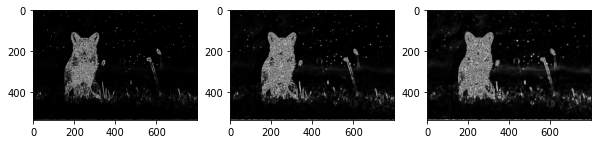

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(np.uint8(texture_image[:,:,0]),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.uint8(texture_image[:,:,1]),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.uint8(texture_image[:,:,2]),cmap='gray')
plt.imsave("fox_text3.jpg",texture_image[:,:,0],cmap='gray')
plt.imsave("fox_text5.jpg",texture_image[:,:,1],cmap='gray')
plt.imsave("fox_text7.jpg",texture_image[:,:,2],cmap='gray')

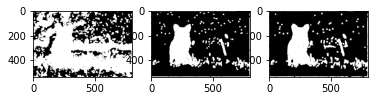

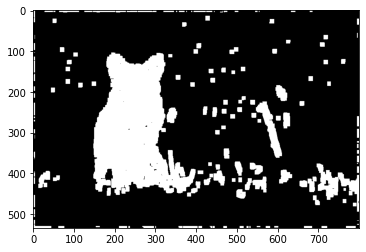

In [ ]:
seg_image_text,[R_k,G_k,B_k]=get_otsu_image(texture_image,round=True,rounds=[1,5,5],invert=[0,0,0],erosion=[3,1],dialation=[5,2])
plt.figure()
plt.imshow(seg_image_text,cmap='gray')
plt.imsave("fox_text_seg.jpg",seg_image_text,cmap='gray')

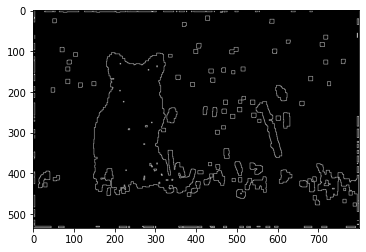

In [ ]:
contour_image_text1 = get_contours(seg_image_text)
plt.imshow(contour_image_text1,cmap='gray')
plt.imsave("fox_text_cont.jpg",contour_image_text1,cmap='gray')

In [ ]:
texture_image=get_texture_image(im2_gray,window_size=[3,5,7])

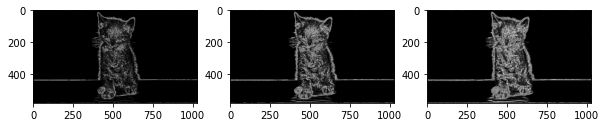

In [ ]:
#var_img2=get_var_image(im1_gray,5)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(np.uint8(texture_image[:,:,0]),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.uint8(texture_image[:,:,1]),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.uint8(texture_image[:,:,2]),cmap='gray')
plt.imsave("cat_text3.jpg",texture_image[:,:,0],cmap='gray')
plt.imsave("cat_text5.jpg",texture_image[:,:,1],cmap='gray')
plt.imsave("cat_text7.jpg",texture_image[:,:,2],cmap='gray')

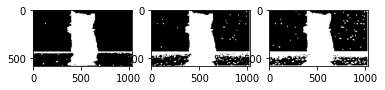

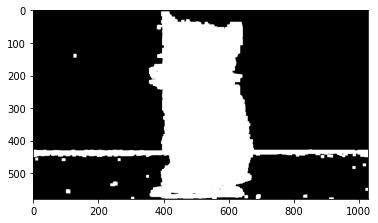

In [ ]:
seg_image_text,[R_k,G_k,B_k]=get_otsu_image(texture_image,round=True,rounds=[1,5,5],invert=[0,0,0],erosion=[3,1],dialation=[5,2])
plt.figure()
plt.imshow(seg_image_text,cmap='gray')
plt.imsave("cat_text_seg.jpg",seg_image_text,cmap='gray')

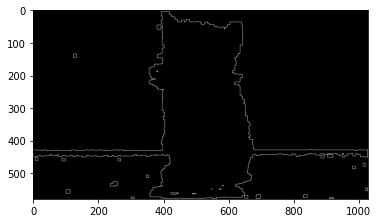

In [ ]:
contour_image_text1 = get_contours(seg_image_text)
plt.imshow(contour_image_text1,cmap='gray')
plt.imsave("cat_text_cont.jpg",contour_image_text1,cmap='gray')

In [ ]:
texture_image=get_texture_image(im3_gray,window_size=[3,5,7])

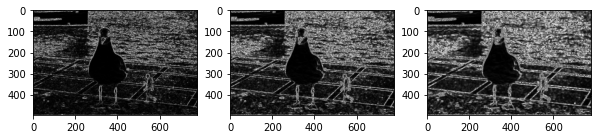

In [ ]:
#var_img2=get_var_image(im1_gray,5)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(np.uint8(texture_image[:,:,0]),cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.uint8(texture_image[:,:,1]),cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.uint8(texture_image[:,:,2]),cmap='gray')
plt.imsave("pig_text3.jpg",texture_image[:,:,0],cmap='gray')
plt.imsave("pig_text5.jpg",texture_image[:,:,1],cmap='gray')
plt.imsave("pig_text7.jpg",texture_image[:,:,2],cmap='gray')

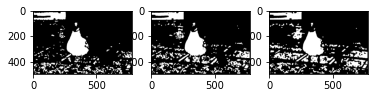

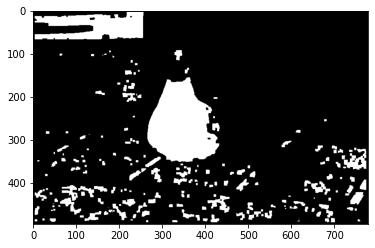

In [ ]:
seg_image_text,[R_k,G_k,B_k]=get_otsu_image(texture_image,round=True,rounds=[5,5,5],invert=[1,1,1],erosion=[3,3],dialation=[5,1])
plt.figure()
plt.imshow(seg_image_text,cmap='gray')
plt.imsave("pig_text_seg.jpg",seg_image_text,cmap='gray')

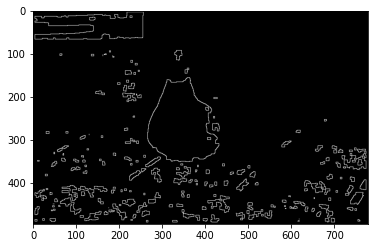

In [ ]:
contour_image_text1 = get_contours(seg_image_text)
plt.imshow(contour_image_text1,cmap='gray')
plt.imsave("pig_text_cont.jpg",contour_image_text1,cmap='gray')